Figure size (inches): [18.  6.]
Figure size (pixels): [1800.  600.]
Canvas class: <class 'ipympl.backend_nbagg.Canvas'>


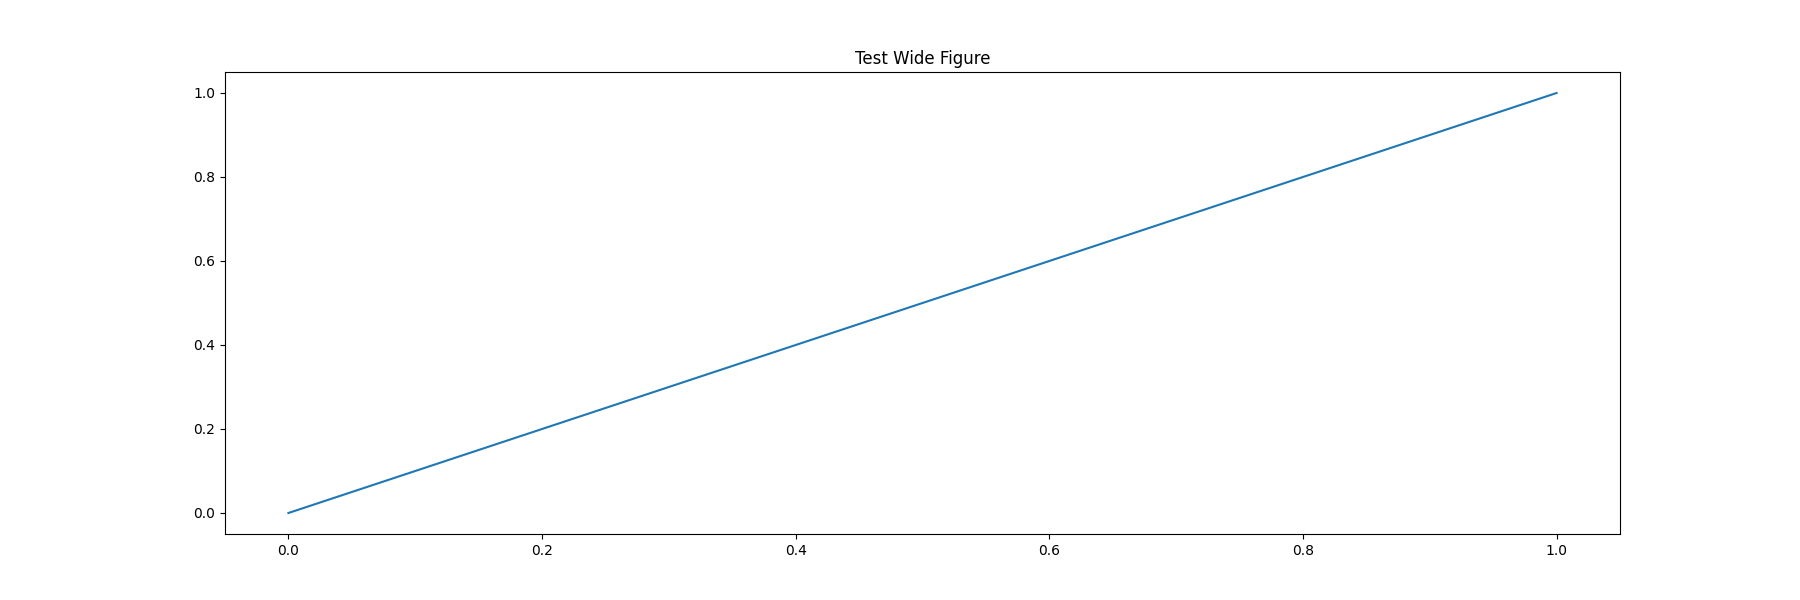

In [10]:
%matplotlib widget
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 6))  # Your 3-image wide figure
plt.plot([0, 1], [0, 1])
plt.title("Test Wide Figure")

# Get canvas size info
canvas = fig.canvas
print(f"Figure size (inches): {fig.get_size_inches()}")
print(f"Figure size (pixels): {fig.get_size_inches() * fig.dpi}")
print(f"Canvas class: {type(canvas)}")

plt.show()

In [1]:
%matplotlib widget

In [2]:
# ====================================================================
# SEM PARTICLE ANALYSIS TOOL - INITIALIZATION
# ====================================================================

# Import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from segment_anything import sam_model_registry, SamPredictor
from ipywidgets import Button, VBox
from IPython.display import display
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import easyocr
import re
from skimage import measure
from skimage.segmentation import clear_border
import random
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

print("Libraries loaded successfully!")

# ====================================================================
# SEGMENT ANYTHING MODEL (SAM) SETUP
# ====================================================================

# SAM model configuration
# NOTE: Update this path to match your SAM checkpoint location
sam_checkpoint = "/Users/sanjaypradeep/segment-anything/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"  # Available options: "vit_h" (best quality), "vit_l", "vit_b" (fastest)

print(" Loading Segment Anything Model...")
print(f"   Model type: {model_type}")
print(f"   Checkpoint: {sam_checkpoint}")

# Verify checkpoint file exists
if not os.path.exists(sam_checkpoint):
    print("❌ ERROR: SAM checkpoint file not found!")
    print(f"   Please check the path: {sam_checkpoint}")
    print("   Download SAM models from: https://github.com/facebookresearch/segment-anything")
else:
    print("✅ Checkpoint file found")

# Load the SAM model
try:
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    predictor = SamPredictor(sam)
    print("✅ SAM model loaded successfully")
except Exception as e:
    print(f"❌ Error loading SAM model: {e}")

# ====================================================================
# DEVICE SETUP (GPU/CPU OPTIMIZATION)
# ====================================================================

# Determine the best available computing device
# Priority: Apple Silicon GPU (MPS) > CUDA GPU > CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU (MPS)"
elif torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = "NVIDIA GPU (CUDA)"
else:
    device = torch.device("cpu")
    device_name = "CPU"

# Move SAM model to the selected device for optimal performance
try:
    sam.to(device)
    print(f" Using device: {device_name}")
    print("   This will accelerate image processing significantly!")
except:
    print(f"⚠️  Warning: Could not move model to {device_name}, using CPU")
    device = torch.device("cpu")
    sam.to(device)

print("\n" + "="*60)
print("INITIALIZATION COMPLETE - Ready for particle analysis!")
print("="*60)

Libraries loaded successfully!
 Loading Segment Anything Model...
   Model type: vit_h
   Checkpoint: /Users/sanjaypradeep/segment-anything/models/sam_vit_h_4b8939.pth
✅ Checkpoint file found
✅ SAM model loaded successfully
 Using device: Apple Silicon GPU (MPS)
   This will accelerate image processing significantly!

INITIALIZATION COMPLETE - Ready for particle analysis!


# Results Management System

This section creates a **persistent data management system** that automatically saves all your particle analysis results and provides tools for managing your data.

## What this system does:

### **Automatic Data Storage**
- Creates a unique CSV file to store all analysis results
- Saves results from each image analysis automatically
- Preserves data between notebook sessions (won't lose your work!)

### **Interactive Data Table**
- Displays all your analysis results in a clean table format
- Shows: filename, particle count, areas, diameters (in both pixels and nanometers)
- Updates automatically after each new analysis

### **Data Management Tools**
- **Delete entries**: Remove incorrect or unwanted results
- **Export data**: Save your complete results to a custom filename
- **Persistent storage**: Data survives notebook restarts

### **Data Columns Explained**
- `file_name`: Name of the analyzed SEM image
- `num_particles`: Total number of particles detected
- `particle_areas_px`: List of particle areas in pixels²
- `equiv_diameters_px`: List of equivalent diameters in pixels
- `particle_areas_nm2`: List of particle areas in nm² (requires scale calibration)
- `equiv_diameters_nm`: List of equivalent diameters in nm (requires scale calibration)

---

In [3]:
# ====================================================================
# RESULTS MANAGEMENT SYSTEM - PERSISTENT DATA STORAGE
# ====================================================================

# ----------------------------------------------------
# 1) Initialize (or reuse) the persistent CSV file
# ----------------------------------------------------

# Create a unique CSV file for this analysis session (if it doesn't exist)
# This ensures your data persists between notebook runs
if 'analysis_csv_file' not in globals():
    # Generate unique filename to avoid conflicts
    suffix = random.randint(1000, 9999)
    analysis_csv_file = f"analysis_results_{suffix}.csv"
    
    # Define the column structure for our results table
    cols = [
        "file_name",              # Name of the analyzed image file
        "num_particles",          # Total count of detected particles
        "particle_areas_px",      # Areas in pixels² (as string list)
        "equiv_diameters_px",     # Equivalent diameters in pixels (as string list)
        "particle_areas_nm2",     # Areas in nm² (requires scale calibration)
        "equiv_diameters_nm"      # Equivalent diameters in nm (requires scale calibration)
    ]
    
    # Create the CSV file with headers if it doesn't exist
    if not os.path.exists(analysis_csv_file):
        pd.DataFrame(columns=cols).to_csv(analysis_csv_file, index=False)
        print(f"Created new results file: {analysis_csv_file}")

# ----------------------------------------------------
# 2) Load current table and define user interface widgets
# ----------------------------------------------------

# Load existing data from CSV
analysis_df = pd.read_csv(analysis_csv_file)

# Create user interface components
table_out = widgets.Output(layout={"border": "1px solid lightgray"})  # Table display area
status_out = widgets.Output()                                          # Status messages area
delete_dropdown = widgets.Dropdown(description='Delete Row:')          # Row selection for deletion
btn_delete = widgets.Button(description='Delete Selected', button_style='danger')  # Delete button
export_name = widgets.Text(description='Export as', placeholder='filename')        # Export filename input
btn_export = widgets.Button(description='Go', button_style='success')             # Export button

# ----------------------------------------------------
# 3) Utility function to refresh the table display
# ----------------------------------------------------

def update_table():
    """
    Refresh the displayed table with current data from CSV.
    Updates both the table view and the delete dropdown options.
    """
    global analysis_df
    
    # Reload data from CSV (in case it was modified externally)
    analysis_df = pd.read_csv(analysis_csv_file)
    
    # Update the table display
    with table_out:
        clear_output(wait=True)
        if len(analysis_df) == 0:
            print("No analysis results yet. Run particle analysis to populate this table.")
        else:
            display(analysis_df)
    
    # Update dropdown options with format "index: filename"
    delete_dropdown.options = [f"{idx}: {fn}" 
                              for idx, fn in analysis_df['file_name'].items()]

# ----------------------------------------------------
# 4) Function to append new analysis results to CSV
# ----------------------------------------------------

def store_analysis_results(
    file_name, num_particles,
    particle_areas_px, equiv_diameters_px,
    particle_areas_nm2, equiv_diameters_nm
):
    """
    Save new particle analysis results to the persistent CSV file.
    
    Parameters:
    - file_name: Name of the analyzed image
    - num_particles: Total number of particles detected
    - particle_areas_px: List of particle areas in pixels
    - equiv_diameters_px: List of equivalent diameters in pixels  
    - particle_areas_nm2: List of particle areas in nm² (if calibrated)
    - equiv_diameters_nm: List of equivalent diameters in nm (if calibrated)
    """
    # Create new row with analysis results
    new_row = {
        "file_name": file_name,
        "num_particles": num_particles,
        "particle_areas_px": particle_areas_px,
        "equiv_diameters_px": equiv_diameters_px,
        "particle_areas_nm2": particle_areas_nm2,
        "equiv_diameters_nm": equiv_diameters_nm
    }
    
    # Append to CSV file (without overwriting existing data)
    pd.DataFrame([new_row]).to_csv(
        analysis_csv_file, mode='a', index=False, header=False
    )
    
    # Refresh the display
    update_table()
    
    # Show confirmation message
    with status_out:
        clear_output()
        print(f"Stored results for '{file_name}' - {num_particles} particles detected")

# ----------------------------------------------------
# 5) Function to delete selected row from results
# ----------------------------------------------------

def delete_entry(_):
    """
    Delete the selected row from the results table.
    Uses the dropdown selection to identify which row to remove.
    """
    with status_out:
        clear_output()
        
        # Get selected item from dropdown
        sel = delete_dropdown.value
        if not sel:
            print("WARNING: No row selected for deletion.")
            return
        
        # Extract index from dropdown selection (format: "index: filename")
        idx_str = sel.split(":", 1)[0]
        try:
            idx = int(idx_str)
        except:
            print(f"ERROR: Could not parse index from '{sel}'.")
            return
        
        # Load current data and verify index exists
        df = pd.read_csv(analysis_csv_file)
        if idx not in df.index:
            print(f"ERROR: Index {idx} not found in current data.")
            return
        
        # Remove the selected row and save back to CSV
        df = df.drop(index=idx)
        df.to_csv(analysis_csv_file, index=False)
        
        # Refresh display and confirm deletion
        update_table()
        print(f"Successfully deleted row {idx}")

# ----------------------------------------------------
# 6) Function to export results to custom filename
# ----------------------------------------------------

def export_table_to_csv(_):
    """
    Export the current results table to a user-specified CSV file.
    Allows users to create permanent copies of their data.
    """
    with status_out:
        clear_output()
        
        # Load current data
        df = pd.read_csv(analysis_csv_file)
        
        # Get user-specified filename
        name = export_name.value.strip()
        if not name:
            print("WARNING: Please enter a filename for export.")
            return
        
        # Add .csv extension if not provided
        outname = f"{name}.csv" if not name.endswith('.csv') else name
        
        # Export data
        df.to_csv(outname, index=False)
        print(f"Successfully exported {len(df)} results to '{outname}'")

# ----------------------------------------------------
# 7) Connect button functions and display the interface
# ----------------------------------------------------

# Connect button click events to their respective functions
btn_delete.on_click(delete_entry)
btn_export.on_click(export_table_to_csv)

# Initialize the table display
update_table()

# Create the control panel layout
controls = widgets.HBox([
    delete_dropdown,  # Select row to delete
    btn_delete,       # Delete button  
    export_name,      # Export filename input
    btn_export        # Export button
])

# Display the complete interface
print("Results Management Interface:")
print("   • Table shows all analysis results")
print("   • Use dropdown + Delete button to remove entries") 
print("   • Enter filename + Go button to export data")
print("   • Data is automatically saved and persists between sessions")

display(controls, table_out, status_out)

Created new results file: analysis_results_9302.csv
Results Management Interface:
   • Table shows all analysis results
   • Use dropdown + Delete button to remove entries
   • Enter filename + Go button to export data
   • Data is automatically saved and persists between sessions


Output(layout=Layout(border_bottom='1px solid lightgray', border_left='1px solid lightgray', border_right='1px…

Output()

# Image Selection and Loading System

This section provides a flexible interface for loading and selecting SEM images from your specified folder.

## Features:

### **Automatic Image Discovery**
- Scans the specified folder for all supported image formats
- Supports: PNG, JPG, JPEG, TIF, TIFF files
- Displays total count and progress tracking

### **Multiple Selection Methods**
- **Sequential browsing**: Navigate through images one by one
- **Dropdown selection**: Choose any specific image by filename
- **Jump navigation**: Go directly to any image number
- **Duplicate detection**: Identifies previously seen images

### **Progress Tracking**
- Visual progress bar showing completion percentage
- Current position indicator (e.g., "5/20 images")
- Prevents reprocessing of already-analyzed images

### **User Controls**
- **Proceed**: Continue with current image for particle analysis
- **Skip**: Move to next image without analyzing
- **Jump**: Go to specific image number
- **Select from dropdown**: Choose any image by filename

---

In [7]:
# ====================================================================
# IMAGE SELECTION AND LOADING SYSTEM
# ====================================================================

import os
import glob
import cv2
import hashlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# ====================================================================
# CONFIGURATION - SET YOUR IMAGE FOLDER HERE
# ====================================================================

INPUT_FOLDER = '/Users/sanjaypradeep/Downloads/Trial images'

# ====================================================================
# INITIALIZE ON FIRST RUN
# ====================================================================

if '___img_paths' not in globals():
    exts = ('*.png', '*.jpg', '*.jpeg', '*.tif', '*.tiff')
    ___img_paths = []
    for e in exts:
        ___img_paths += glob.glob(os.path.join(INPUT_FOLDER, e))
    ___img_paths = sorted(___img_paths)
    ___img_idx = -1
    ___seen_hashes = set()
    total_images = len(___img_paths)
    # create progress bar and label
    progress_bar = widgets.IntProgress(value=0, min=0, max=total_images, description='Progress:')
    progress_label = widgets.Label(value=f"0/{total_images} (0.0%)")
    print(f"Found {total_images} images in '{INPUT_FOLDER}'")

# Define output area and buttons
out = widgets.Output()
btn_proceed = widgets.Button(description="Proceed", button_style='success')
btn_skip = widgets.Button(description="Skip", button_style='warning')

# Jump navigation controls
jump_input = widgets.IntText(
    value=1,
    min=1,
    max=total_images,
    description='Jump to #:',
    style={'description_width': 'initial'}
)
btn_jump = widgets.Button(description="Jump", button_style='info')

def update_progress():
    """Update progress bar and label"""
    done = min(___img_idx + 1, total_images)
    progress_bar.value = done
    pct = (done / total_images) * 100 if total_images else 0
    progress_label.value = f"{done}/{total_images} ({pct:.1f}%)"

def load_image_by_index(target_idx):
    """Load a specific image by index"""
    global ___img_idx, image_path, image_rgb, last_hash
    
    # Validate index
    if target_idx < 0 or target_idx >= total_images:
        with out:
            clear_output()
            print(f"Invalid image number. Please choose between 1 and {total_images}")
        return False
    
    ___img_idx = target_idx
    update_progress()
    
    image_path = ___img_paths[___img_idx]
    bgr = cv2.imread(image_path)
    if bgr is None:
        with out:
            clear_output()
            print(f"Could not load image: {os.path.basename(image_path)}")
        return False
        
    image_rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    last_hash = hashlib.md5(image_rgb.tobytes()).hexdigest()
    
    with out:
        clear_output()
        plt.figure(figsize=(8, 6))
        plt.imshow(image_rgb)
        plt.title(f"{os.path.basename(image_path)} (#{___img_idx + 1}/{total_images})")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        if last_hash in ___seen_hashes:
            print("Duplicate image (seen before).")
        else:
            print("New image ready for analysis.")
        
        print(f"Image dimensions: {image_rgb.shape[1]} x {image_rgb.shape[0]} pixels")
    
    return True

def load_next():
    """Load next sequential image"""
    global ___img_idx
    
    while True:
        ___img_idx += 1
        
        if ___img_idx >= total_images:
            with out:
                clear_output()
                print("All images processed!")
            btn_proceed.disabled = True
            btn_skip.disabled = True
            btn_jump.disabled = True
            return
        
        if load_image_by_index(___img_idx):
            break

# Button callbacks
def on_proceed(b):
    ___seen_hashes.add(last_hash)
    with out:
        print(f"PROCEEDING with: {os.path.basename(image_path)}")
        print("Continue to the next cell for scale bar detection.")
    btn_proceed.disabled = True
    btn_skip.disabled = True
    btn_jump.disabled = True

def on_skip(b):
    ___seen_hashes.add(last_hash)
    load_next()

def on_jump(b):
    """Jump to specific image number"""
    target_number = jump_input.value
    target_idx = target_number - 1  # Convert from 1-based to 0-based indexing
    
    if load_image_by_index(target_idx):
        # Update jump input to show current position
        jump_input.value = ___img_idx + 1

# Wire up event handlers
btn_proceed.on_click(on_proceed)
btn_skip.on_click(on_skip)
btn_jump.on_click(on_jump)

# Display UI with jump controls
display(widgets.VBox([
    progress_bar,
    progress_label,
    widgets.HBox([jump_input, btn_jump]),
    out,
    widgets.HBox([btn_proceed, btn_skip])
]))

# Load first image
load_next()

# Scale Bar Detection and Calibration

This section automatically detects the scale bar in your SEM images and calculates the pixel-to-nanometer conversion factor.

## What this does:

### **Automatic Scale Bar Detection**
- Scans the bottom region of the image for scale bar text and markings
- Uses OCR (Optical Character Recognition) to read scale values and units
- Supports common SEM units: nm, μm, um, pm
- Calculates pixel-to-nanometer conversion factor

### **Interactive Region Adjustment**
- Shows a red box around the detected scale bar region
- Allows manual adjustment if automatic detection is incorrect
- Provides sliders to modify region position and size
- Real-time preview of the selected area

### **Image Preprocessing**
- Automatically crops bottom portion of image (removes scale bar from analysis area)
- Applies threshold filtering to isolate scale bar markings
- Measures scale bar length in pixels for accurate calibration

### **Quality Control**
- Displays detected OCR text for verification
- Shows measured pixel length and calculated conversion factor
- Allows re-processing if scale bar detection fails

---

In [5]:
# ====================================================================
# SCALE BAR DETECTION AND CALIBRATION SYSTEM
# ====================================================================

# Check if an image has been loaded from the previous step
if 'image_rgb' not in globals() or image_rgb is None:
    print("ERROR: No image loaded. Please run the previous cell to select an image first.")
else:
    print(f"Processing scale bar for: {os.path.basename(image_path)}")

# ====================================================================
# INTERACTIVE SCALE BAR REGION SELECTOR
# ====================================================================

# Default scale bar detection parameters
DEFAULT_FRAC_W = 0.5      # Width fraction of image to search (50%)
DEFAULT_FRAC_H = 0.06     # Height fraction of image to search (6%)
DEFAULT_THRESHOLD = 250    # Threshold for scale bar detection
DEFAULT_CROP_PERCENT = 7.0 # Percentage to crop from bottom

# Create interactive controls
region_controls = widgets.VBox([
    widgets.HTML("<h3>Scale Bar Region Controls</h3>"),
    widgets.FloatSlider(
        value=DEFAULT_FRAC_W, min=0.1, max=1.0, step=0.05,
        description='Region Width:', style={'description_width': 'initial'}
    ),
    widgets.FloatSlider(
        value=DEFAULT_FRAC_H, min=0.02, max=0.2, step=0.01,
        description='Region Height:', style={'description_width': 'initial'}
    ),
    widgets.FloatSlider(
        value=0.0, min=0.0, max=0.3, step=0.02,
        description='Vertical Offset:', style={'description_width': 'initial'}
    ),
    widgets.IntSlider(
        value=DEFAULT_THRESHOLD, min=100, max=255, step=10,
        description='Threshold:', style={'description_width': 'initial'}
    ),
    widgets.FloatSlider(
        value=DEFAULT_CROP_PERCENT, min=0.0, max=20.0, step=1.0,
        description='Bottom Crop %:', style={'description_width': 'initial'}
    )
])

# Get slider references
width_slider = region_controls.children[1]
height_slider = region_controls.children[2] 
offset_slider = region_controls.children[3]
threshold_slider = region_controls.children[4]
crop_slider = region_controls.children[5]

# Control buttons
btn_detect = widgets.Button(description="Detect Scale Bar", button_style='primary')
btn_accept = widgets.Button(description="Accept & Continue", button_style='success')
btn_manual = widgets.Button(description="Manual Entry", button_style='warning')

# Output areas
detection_output = widgets.Output()
status_output = widgets.Output()

# Global variables for scale bar data
scale_bar_data = {}

# ====================================================================
# SCALE BAR DETECTION FUNCTIONS
# ====================================================================

def detect_scale_bar():
    """
    Detect and measure the scale bar in the current image.
    Uses the current slider settings to define the search region.
    """
    global scale_bar_data
    
    try:
        with status_output:
            clear_output()
            print("Detecting scale bar...")
        
        # Get current parameter values from sliders
        frac_w = width_slider.value
        frac_h = height_slider.value
        v_offset = offset_slider.value
        threshold = int(threshold_slider.value)
        
        # Calculate search region coordinates
        H, W = image_rgb.shape[:2]
        box_w = int(W * frac_w)
        box_h = int(H * frac_h)
        
        # Apply vertical offset (0 = bottom of image)
        y_offset = int(H * v_offset)
        x0 = W - box_w
        y0 = H - box_h - y_offset
        
        # Ensure coordinates are within image bounds
        x0 = max(0, min(x0, W - box_w))
        y0 = max(0, min(y0, H - box_h))
        
        # Extract the region of interest
        crop = image_rgb[y0:y0 + box_h, x0:x0 + box_w]
        gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
        
        # Apply threshold to isolate scale bar
        _, binary255 = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
        binary = (binary255 > 0).astype(np.uint8)
        
        if not binary.any():
            raise ValueError(f"No white pixels found with threshold {threshold}. Try lowering the threshold.")
        
        # Find the scale bar line (topmost row of white pixels)
        coords = np.column_stack(np.where(binary))
        top_row = coords[:, 0].min()
        cols_on_top = coords[coords[:, 0] == top_row][:, 1]
        leftmost = int(cols_on_top.min())
        rightmost = int(cols_on_top.max())
        pixel_length = rightmost - leftmost
        y_line = top_row
        
        # Perform OCR on the region
        reader = easyocr.Reader(['en'], gpu=False)
        ocr_pairs = reader.readtext(crop)
        ocr_text = " ".join(txt for _, txt, _ in ocr_pairs)
        
        # Extract scale value and units using regex
        import re
        pattern = r'(\d+(?:\.\d+)?)\s*(nm|um|µm|uum|pm)'
        match = re.search(pattern, ocr_text, flags=re.I)
        
        if not match:
            raise ValueError(f"Could not extract scale information from OCR text: '{ocr_text}'")
        
        # Parse the scale information
        value = float(match.group(1))
        unit = match.group(2).lower()
        
        # Convert to nanometers
        if unit in {'um', 'µm', 'uum','pm'}:
            scale_nm = value * 1000.0  # micrometers to nanometers
        else:  # nm
            scale_nm = value
        
        # Calculate conversion factor (nm per pixel)
        conversion = scale_nm / pixel_length
        
        # Store results
        scale_bar_data = {
            'region': (x0, y0, box_w, box_h),
            'pixel_length': pixel_length,
            'scale_nm': scale_nm,
            'conversion': conversion,
            'ocr_text': ocr_text,
            'binary_image': binary255,
            'line_coords': (leftmost, rightmost, y_line),
            'threshold': threshold
        }
        
        # Display results
        display_detection_results()
        
        with status_output:
            clear_output()
            print("SUCCESS: Scale bar detected successfully!")
            print(f"Scale: {pixel_length} pixels = {scale_nm:.1f} nm")
            print(f"Conversion: {conversion:.3f} nm/pixel")
            
        # Enable the accept button
        btn_accept.disabled = False
        
    except Exception as e:
        with status_output:
            clear_output()
            print(f"ERROR: Scale bar detection failed")
            print(f"Details: {str(e)}")
            print("Try adjusting the region parameters or threshold value.")
        
        btn_accept.disabled = True

def display_detection_results():
    """Display the detection results with visual feedback"""
    if not scale_bar_data:
        return
    
    with detection_output:
        clear_output(wait=True)
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # 1. Full image with detection region highlighted
        ax1 = axes[0]
        ax1.imshow(image_rgb)
        
        # Draw red rectangle around detection region
        x0, y0, box_w, box_h = scale_bar_data['region']
        rect = plt.Rectangle((x0, y0), box_w, box_h, 
                           fill=False, edgecolor='red', linewidth=2)
        ax1.add_patch(rect)
        ax1.set_title("Full Image with Scale Bar Region")
        ax1.axis('off')
        
        # 2. Scale bar region with measurement
        ax2 = axes[1]
        binary_img = scale_bar_data['binary_image']
        ax2.imshow(binary_img, cmap='gray', vmin=0, vmax=255)
        
        # Draw measurement line
        leftmost, rightmost, y_line = scale_bar_data['line_coords']
        ax2.plot([leftmost, rightmost], [y_line, y_line], 'r-', linewidth=3)
        ax2.text(rightmost + 5, y_line, f"{scale_bar_data['pixel_length']} px", 
                color='red', fontsize=12, fontweight='bold', va='center')
        
        # Show OCR text
        ax2.text(5, 15, f"OCR: {scale_bar_data['ocr_text']}", 
                color='yellow', fontsize=10,
                bbox=dict(facecolor='black', alpha=0.7, pad=4))
        
        ax2.set_title(f"Scale Bar Detection (Threshold: {scale_bar_data['threshold']})")
        ax2.axis('off')
        
        # 3. Preview of cropped image
        ax3 = axes[2]
        crop_percent = crop_slider.value
        height = image_rgb.shape[0]
        crop_height = int(height * (1 - crop_percent / 100))
        cropped_image = image_rgb[:crop_height, :]
        
        ax3.imshow(cropped_image)
        ax3.set_title(f"Analysis Image (Bottom {crop_percent:.1f}% Removed)")
        ax3.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Display measurement summary
        print("SCALE BAR DETECTION RESULTS:")
        print(f"  Pixel length: {scale_bar_data['pixel_length']} pixels")
        print(f"  Physical length: {scale_bar_data['scale_nm']:.1f} nm") 
        print(f"  Conversion factor: {scale_bar_data['conversion']:.3f} nm/pixel")
        print(f"  OCR text: '{scale_bar_data['ocr_text']}'")

def accept_scale_bar():
    """Accept the current scale bar detection and prepare for analysis"""
    global conversion, modified_image
    
    if not scale_bar_data:
        with status_output:
            clear_output()
            print("ERROR: No scale bar data available. Please detect scale bar first.")
        return
    
    # Set global variables for use in subsequent analysis
    conversion = scale_bar_data['conversion']
    
    # Create the cropped image for analysis
    crop_percent = crop_slider.value
    height = image_rgb.shape[0]
    crop_height = int(height * (1 - crop_percent / 100))
    modified_image = image_rgb[:crop_height, :].copy()
    
    with status_output:
        clear_output()
        print("SCALE BAR ACCEPTED!")
        print(f"Conversion factor set to: {conversion:.3f} nm/pixel")
        print(f"Analysis image prepared (cropped to {crop_height} x {image_rgb.shape[1]} pixels)")
        print("Ready to proceed to particle detection!")
    
    # Disable controls to prevent changes during analysis
    btn_detect.disabled = True
    btn_accept.disabled = True
    for slider in [width_slider, height_slider, offset_slider, threshold_slider, crop_slider]:
        slider.disabled = True

def manual_entry():
    """Allow manual entry of scale bar information"""
    # Create manual entry widgets
    manual_widgets = widgets.VBox([
        widgets.HTML("<h4>Manual Scale Bar Entry</h4>"),
        widgets.FloatText(description='Scale (nm):', value=100.0),
        widgets.IntText(description='Length (pixels):', value=50),
        widgets.Button(description='Set Manual Scale', button_style='success')
    ])
    
    def set_manual_scale(b):
        scale_nm = manual_widgets.children[1].value
        pixel_length = manual_widgets.children[2].value
        
        if scale_nm <= 0 or pixel_length <= 0:
            print("ERROR: Scale and pixel length must be positive values")
            return
        
        global conversion, modified_image
        conversion = scale_nm / pixel_length
        
        # Create cropped image
        crop_percent = crop_slider.value
        height = image_rgb.shape[0]
        crop_height = int(height * (1 - crop_percent / 100))
        modified_image = image_rgb[:crop_height, :].copy()
        
        with status_output:
            clear_output()
            print("MANUAL SCALE SET!")
            print(f"Conversion factor: {conversion:.3f} nm/pixel")
            print("Ready to proceed to particle detection!")
    
    manual_widgets.children[3].on_click(set_manual_scale)
    
    with detection_output:
        clear_output()
        display(manual_widgets)

# ====================================================================
# CONNECT BUTTON EVENTS AND DISPLAY INTERFACE
# ====================================================================

# Connect button events
btn_detect.on_click(lambda b: detect_scale_bar())
btn_accept.on_click(lambda b: accept_scale_bar())
btn_manual.on_click(lambda b: manual_entry())

# Initially disable accept button
btn_accept.disabled = True

# Create complete interface
button_controls = widgets.HBox([btn_detect, btn_accept, btn_manual])

print("SCALE BAR CALIBRATION INTERFACE:")
print("1. Adjust the sliders to position the detection region over the scale bar")
print("2. Click 'Detect Scale Bar' to automatically find and measure the scale")
print("3. Review the results and click 'Accept & Continue' if correct")
print("4. Use 'Manual Entry' if automatic detection fails")

display(widgets.VBox([
    region_controls,
    button_controls,
    status_output,
    detection_output
]))

# Run initial detection
detect_scale_bar()

Processing scale bar for: A2-A_009.tif
SCALE BAR CALIBRATION INTERFACE:
1. Adjust the sliders to position the detection region over the scale bar
2. Click 'Detect Scale Bar' to automatically find and measure the scale
3. Review the results and click 'Accept & Continue' if correct
4. Use 'Manual Entry' if automatic detection fails


Using CPU. Note: This module is much faster with a GPU.


# SAM-Based Particle Segmentation

This section uses the Segment Anything Model (SAM) to automatically detect and segment individual particles in your SEM image.

## What this does:

### **Automatic Particle Detection**
- Uses the processed image from the previous step as input to SAM
- Applies SAM's AI-powered segmentation to identify individual particles
- Generates multiple mask options with confidence scores
- Handles both preprocessed and original images depending on your previous choices

### **Multiple Mask Generation**
- SAM produces 3 different segmentation approaches
- Each mask has a confidence score indicating SAM's certainty
- You can compare results to choose the best segmentation
- Higher scores generally indicate better particle detection

### **Visual Output**
- Displays all generated masks side-by-side for comparison
- Shows confidence scores for each mask
- Binary visualization: white particles on black background
- Allows you to select the best mask for particle analysis

---

Using cropped image: (1017, 1536, 3)
Running SAM image encoder (this runs only once)...
Image encoder complete! All future predictions will be fast.
Confidence scores for the masks: [1.007692  1.0056477 1.0003562]


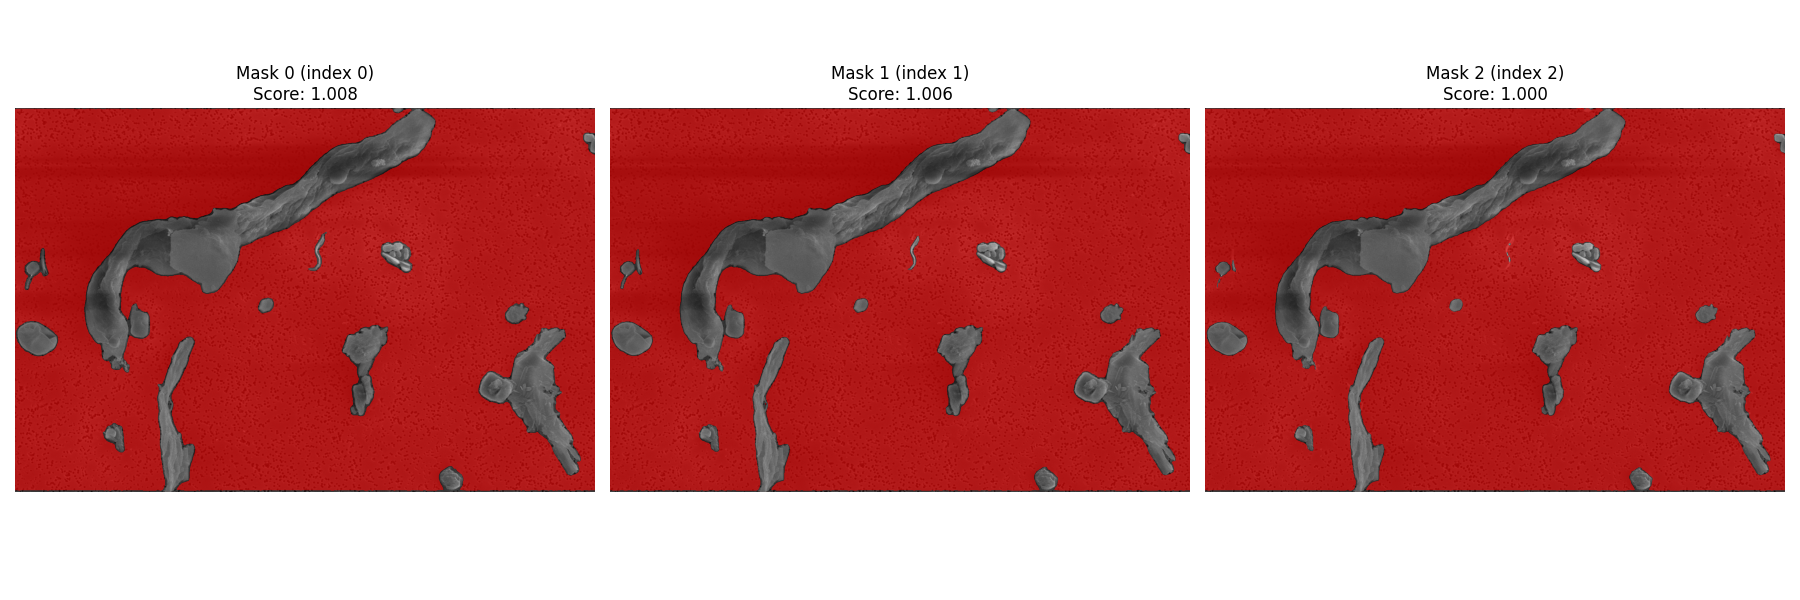


Select your preferred mask and click 'Confirm Selection':


In [6]:
# ====================================================================
# SAM-BASED PARTICLE SEGMENTATION WITH MASK SELECTION
# ====================================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Verify that the cropped image exists from scale bar processing
try:
    modified_image
    print(f"Using cropped image: {modified_image.shape}")
except NameError:
    print("ERROR: No cropped image found. Please run the scale bar processing step first.")
    raise ValueError("The variable 'modified_image' is not defined. Please run the scale bar step.")

# Check if SAM predictor is available
try:
    predictor
except NameError:
    print("ERROR: SAM predictor not found. Please run the initialization cell.")
    raise ValueError("SAM predictor is not initialized.")

# Set the cropped image in the SAM predictor (THIS RUNS ONLY ONCE - image encoder)
print("Running SAM image encoder (this runs only once)...")
predictor.set_image(modified_image)
print("Image encoder complete! All future predictions will be fast.")

# Define a full-image bounding box as the prompt
height, width = modified_image.shape[:2]
full_box = np.array([[0, 0, width, height]])

# Generate masks using SAM
masks, scores, logits = predictor.predict(box=full_box, multimask_output=True)
print("Confidence scores for the masks:", scores)

# Display the masks with red overlays
def plot_masks_with_overlay(image, masks, scores):
    """Plot masks with red overlay on the original image"""
    num_masks = len(masks)
    plt.figure(figsize=(6 * num_masks, 6))
    
    for idx, mask in enumerate(masks):
        plt.subplot(1, num_masks, idx + 1)
        
        # Show original image
        plt.imshow(image)
        
        # Create red overlay for detected particles
        overlay = np.zeros((*mask.shape, 4))  # RGBA
        overlay[mask] = [1, 0, 0, 0.6]  # Semi-transparent red
        plt.imshow(overlay)
        
        # Add title with score
        plt.title(f"Mask {idx} (index {idx})\nScore: {scores[idx]:.3f}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Plot the resulting masks
plot_masks_with_overlay(modified_image, masks, scores)

# Interactive mask selector
mask_selector = widgets.Dropdown(
    options=[(f"Mask {i} (score: {scores[i]:.3f})", i) for i in range(len(masks))],
    value=np.argmax(scores),
    description='Select Mask:',
)

confirm_button = widgets.Button(
    description='Confirm Selection',
    button_style='success',
    tooltip='Click to confirm your mask selection'
)

output = widgets.Output()

def on_confirm(b):
    global selected_mask_index, selected_mask
    selected_mask_index = mask_selector.value
    selected_mask = masks[selected_mask_index]
    with output:
        output.clear_output()
        print(f"✓ Selected mask {selected_mask_index} with score {scores[selected_mask_index]:.3f}")
        print("You can now proceed to the next cell for particle analysis.")

confirm_button.on_click(on_confirm)

print("\nSelect your preferred mask and click 'Confirm Selection':")
display(widgets.VBox([mask_selector, confirm_button, output]))

# Initialize with best mask
selected_mask_index = np.argmax(scores)
selected_mask = masks[selected_mask_index]

Using selected mask 1
Number of particles (border artifacts removed): 2


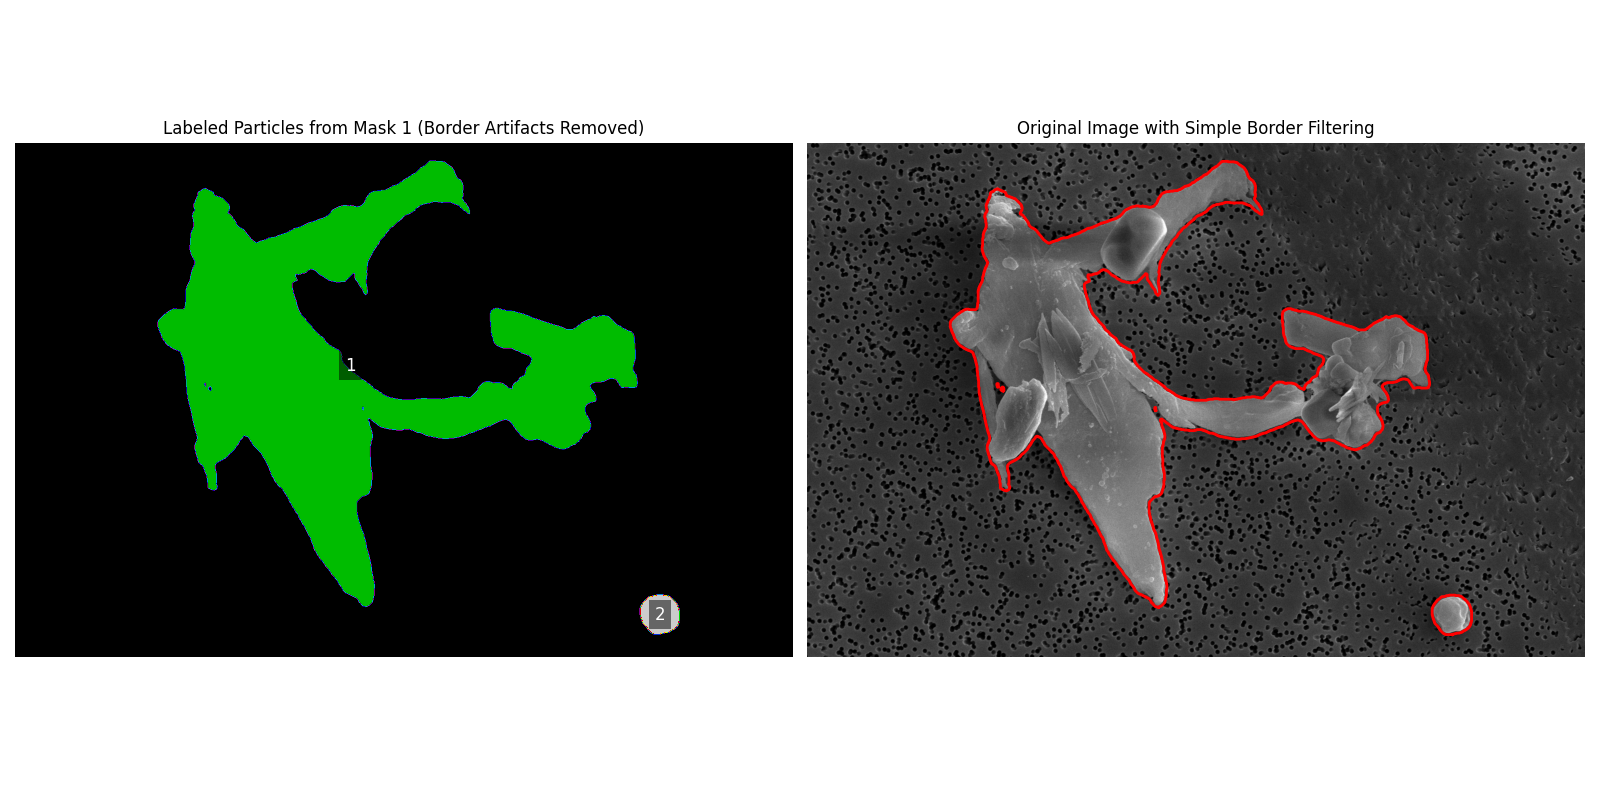


You can now proceed to the interactive refinement cell.


In [44]:
# ====================================================================
# PARTICLE ANALYSIS WITH TARGETED EDGE ARTIFACT REMOVAL
# ====================================================================
from skimage import measure, morphology
import matplotlib.pyplot as plt
import numpy as np

# Verify selected mask exists
try:
    selected_mask
    selected_mask_index
    print(f"Using selected mask {selected_mask_index}")
except NameError:
    print("ERROR: No mask selected. Please run the previous cell and select a mask.")
    raise ValueError("Run the SAM segmentation cell first and select a mask.")

# Convert to a binary image: invert so that particles become 1 and background 0
binary_mask = (1 - selected_mask.astype(np.uint8))

# Remove small objects (noise) from the binary mask
clean_mask = morphology.remove_small_objects(binary_mask.astype(bool), min_size=30)

# ====================================================================
# SIMPLE EDGE ARTIFACT REMOVAL
# ====================================================================
def remove_border_artifacts(mask, border_width=20):
    """
    Remove only the pixels that are directly on the image border.
    This removes thin edge strips without affecting particle interiors.
    """
    cleaned = mask.copy()
    height, width = mask.shape
    
    # Simply zero out pixels that are right at the borders
    cleaned[0:border_width, :] = False      # Top border
    cleaned[-border_width:, :] = False      # Bottom border  
    cleaned[:, 0:border_width] = False      # Left border
    cleaned[:, -border_width:] = False      # Right border
    
    return cleaned

# Apply border cleaning - this removes only the outermost pixels
border_cleaned_mask = remove_border_artifacts(clean_mask, border_width=4)

# Now label and analyze the remaining regions
labeled_mask = measure.label(border_cleaned_mask, connectivity=2)
regions = measure.regionprops(labeled_mask)

# Optional: Remove very small remaining artifacts
min_area = 50  # Adjust based on your typical particle sizes
filtered_regions = [region for region in regions if region.area >= min_area]

# Build final mask - THIS IS WHAT GETS PASSED TO THE INTERACTIVE CELL
filtered_mask = np.zeros_like(border_cleaned_mask, dtype=bool)
for region in filtered_regions:
    filtered_mask[labeled_mask == region.label] = True

# ====================================================================
# PRINT MEASUREMENTS
# ====================================================================
num_particles = len(filtered_regions)
particle_areas = [region.area for region in filtered_regions]
equiv_diameters = [region.equivalent_diameter for region in filtered_regions]
print(f"Number of particles (border artifacts removed): {num_particles}")

# ====================================================================
# VISUALIZATIONS - SIDE BY SIDE
# ====================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left plot: Labeled particles with annotations
axes[0].imshow(measure.label(filtered_mask, connectivity=2), cmap='nipy_spectral')
for idx, region in enumerate(filtered_regions, start=1):
    y, x = region.centroid
    axes[0].text(x, y, str(idx),
                 color='white', fontsize=12, ha='center', va='center',
                 bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
axes[0].set_title(f"Labeled Particles from Mask {selected_mask_index} (Border Artifacts Removed)")
axes[0].axis("off")

# Right plot: Red borders on original image
contours = measure.find_contours(filtered_mask.astype(float), level=0.5)
axes[1].imshow(modified_image)
for contour in contours:
    axes[1].plot(contour[:, 1], contour[:, 0], color='red', linewidth=2)
axes[1].set_title("Original Image with Simple Border Filtering")
axes[1].axis("off")

plt.tight_layout()
plt.show()

print("\nYou can now proceed to the interactive refinement cell.")

HTML(value="Select/Delete mode: toggle 'Merge mode' ON to select regions for merge with left-click; when OFF, …

HTML(value='<b>Particles:</b> 13')

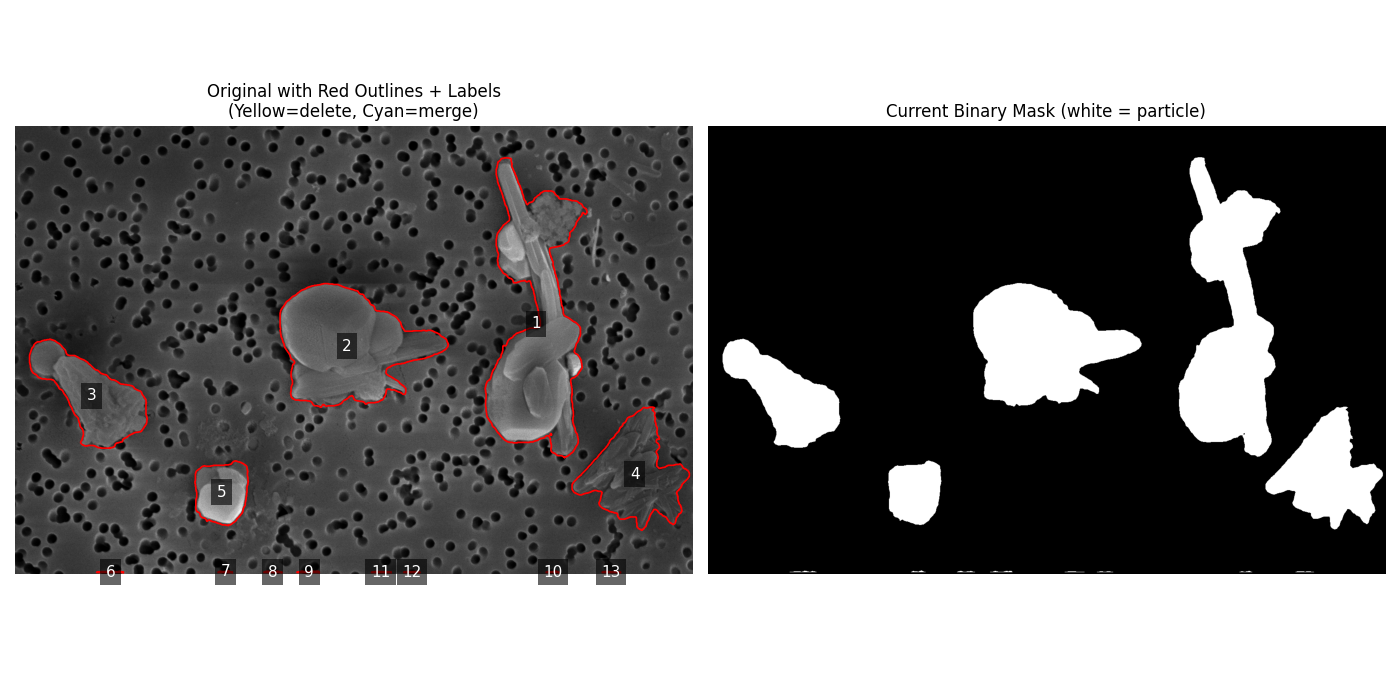

In [40]:
# ====================================================================
# INTERACTIVE PARTICLE REFINEMENT (SELECT/DELETE + SAM) WITH DUAL VIEWS
# Bounding-box mask + click-to-refine (union with base) + Clear Edges
# ====================================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology
from skimage.segmentation import clear_border
import ipywidgets as widgets
from IPython.display import display

# --------------------------------------------------------------------
# If clicks don't register in your environment, make sure you're using
# an interactive Matplotlib backend, e.g. run in a separate cell:
#   %matplotlib widget
# --------------------------------------------------------------------

# ----------------------------- Guards --------------------------------
_required = ['modified_image', 'predictor', 'filtered_mask', 'filtered_regions']
_missing = [v for v in _required if v not in globals()]
if _missing:
    raise NameError(f"Missing upstream variables: {_missing}. "
                    "Run the SAM segmentation + particle analysis cells first.")

# Ensure SAM has the current image bound (safe to repeat)
try:
    predictor.set_image(modified_image)
except Exception as e:
    print(f"Warning: predictor.set_image failed: {e}")

# ------------------------- Working state ------------------------------
current_mask = filtered_mask.astype(bool).copy()
H, W = current_mask.shape

# FULL-IMAGE BOUNDING BOX FOR SAM (x0, y0, x1, y1) – fallback
full_box = np.array([[0, 0, W, H]])

def remove_border_artifacts(mask, border_width=4):
    m = mask.copy()
    m[:border_width, :] = False
    m[-border_width:, :] = False
    m[:, :border_width] = False
    m[:, -border_width:] = False
    return m

def analyze_and_refresh(min_size=20, min_area=50):
    """Recompute labeled regions from current_mask with light cleanup."""
    global current_labeled, current_regions
    clean = morphology.remove_small_objects(current_mask.astype(bool), min_size=min_size)
    clean = remove_border_artifacts(clean, border_width=4)
    current_labeled = measure.label(clean, connectivity=2)
    regs = measure.regionprops(current_labeled)
    current_regions = [r for r in regs if r.area >= min_area]

analyze_and_refresh()

# Queued operations (Select/Delete mode)
pending_delete_labels = set()
pending_add_points = []
pending_merge_labels = set()   # regions selected for merge

# SAM refinement state
sam_points = []               # [[x,y], ...]
sam_labels = []               # [1 (pos), 0 (neg)]
current_sam_mask = None       # live preview = refined mask
base_mask = None              # snapshot of current mask when entering SAM

# -------------------------- Helpers ----------------------------------
def _draw_contours_on_axes(ax, mask_bool, color='red', lw=1.5, alpha=1.0):
    for ctr in measure.find_contours(mask_bool.astype(float), 0.5):
        ax.plot(ctr[:, 1], ctr[:, 0], color=color, lw=lw, alpha=alpha, zorder=5)

def _sam_predict(points_xy, labels01, multimask_output=True, box=None):
    """
    Wrapper around predictor.predict.

    points_xy: list of [x, y] in image coords
    labels01:  list of 1 (positive) / 0 (negative)
    box:       optional [x0, y0, x1, y1] box
    """
    if len(points_xy) == 0:
        return None, None
    pts = np.array(points_xy, dtype=float)
    pts[:, 0] = np.clip(pts[:, 0], 0, W - 1)
    pts[:, 1] = np.clip(pts[:, 1], 0, H - 1)
    labs = np.array(labels01, dtype=int)
    masks_out, scores, _ = predictor.predict(
        point_coords=pts,
        point_labels=labs,
        box=box,
        multimask_output=multimask_output
    )
    return masks_out.astype(bool), scores

def _black_mask_view(mask_bool):
    img = np.zeros((H, W), dtype=np.float32)
    if mask_bool is not None:
        img[mask_bool] = 1.0
    return img

def count_regions_from_mask(mask_bool):
    if mask_bool is None:
        return 0, None, []
    lbl = measure.label(mask_bool, connectivity=2)
    regs = measure.regionprops(lbl)
    return len(regs), lbl, regs

def _compute_roi_box_from_basemask(pad=10):
    """
    Build a padded ROI box from base_mask.
    If base_mask is empty or None, fall back to full_box.
    """
    if base_mask is None or not base_mask.any():
        return full_box
    ys, xs = np.where(base_mask)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()
    x0 = max(0, x0 - pad)
    y0 = max(0, y0 - pad)
    x1 = min(W - 1, x1 + pad)
    y1 = min(H - 1, y1 + pad)
    return np.array([[x0, y0, x1, y1]])

def _mask_iou(m1, m2):
    """IoU between two boolean masks (same shape)."""
    inter = np.logical_and(m1, m2).sum()
    union = np.logical_or(m1, m2).sum()
    if union == 0:
        return 0.0
    return inter / union

# --------------------------- UI --------------------------------------
mode_toggle = widgets.ToggleButtons(
    options=[('Select/Delete Particles', 'select'), ('Refine with SAM', 'sam')],
    value='select',
    description='Mode:',
    button_style='info'
)

merge_mode_toggle = widgets.ToggleButton(   # NEW: merge mode toggle
    value=False,
    description='Merge mode',
    button_style='',  # 'info' when on, we’ll set dynamically in redraw
    tooltip='Toggle: left-click selects regions to merge instead of delete'
)

# Select/Delete controls
update_btn = widgets.Button(description="Update (apply queued ops)", button_style='primary')
clear_queue_btn = widgets.Button(description="Clear queued ops", button_style='warning')
merge_btn = widgets.Button(description="Merge selected", button_style='')  # merges queued regions
edge_buffer_sel = widgets.IntSlider(value=0, min=0, max=50, step=1, description='Buffer(px):', continuous_update=False)
clear_edges_btn_select = widgets.Button(description="Clear Edges", button_style='danger',
                                        tooltip="Remove components touching the border or within buffer")
finish_btn_select = widgets.Button(description="Finish", button_style='success',
                                   tooltip="Store current analysis results")

# SAM controls
clear_sam_btn = widgets.Button(description="Clear SAM points", button_style='warning')
apply_sam_btn = widgets.Button(description="Apply SAM to mask", button_style='success')
edge_buffer_sam = widgets.IntSlider(value=0, min=0, max=50, step=1, description='Buffer(px):', continuous_update=False)
clear_edges_btn_sam = widgets.Button(description="Clear Edges", button_style='danger',
                                     tooltip="Remove components touching the border or within buffer")
finish_btn_sam = widgets.Button(description="Finish", button_style='success',
                                tooltip="Store current analysis results")

# Status labels
status_label = widgets.HTML("")
count_label = widgets.HTML("")

# Layout rows
top_row = widgets.HBox([mode_toggle, merge_mode_toggle])
select_controls = widgets.HBox([
    update_btn,
    clear_queue_btn,
    merge_btn,
    edge_buffer_sel,
    clear_edges_btn_select,
    finish_btn_select
])
sam_controls = widgets.HBox([clear_sam_btn, apply_sam_btn, edge_buffer_sam, clear_edges_btn_sam, finish_btn_sam])

# ------------------------ Figure setup --------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
ax_left, ax_right = axes

def _scatter_points(ax):
    """Draw SAM points with high contrast and zorder so they are always visible."""
    if not sam_points:
        return
    pts = np.array(sam_points, dtype=float)
    labs = np.array(sam_labels, dtype=int)
    if (labs == 1).any():
        pos = pts[labs == 1]
        ax.scatter(pos[:, 0], pos[:, 1], marker='+', s=160, linewidths=3,
                   c='lime', zorder=50)
    if (labs == 0).any():
        neg = pts[labs == 0]
        ax.scatter(neg[:, 0], neg[:, 1], marker='x', s=160, linewidths=3,
                   c='red', zorder=50)

def redraw():
    """Redraw both panes depending on mode."""
    ax_left.clear()
    ax_right.clear()

    # style merge toggle
    merge_mode_toggle.button_style = 'info' if merge_mode_toggle.value else ''

    if mode_toggle.value == 'select':
        # LEFT: original image + red outlines + labels
        ax_left.imshow(modified_image)
        for i, r in enumerate(current_regions, start=1):
            mask_i = (current_labeled == r.label)
            _draw_contours_on_axes(ax_left, mask_i, color='red', lw=1.2)
            y, x = r.centroid
            ax_left.text(x, y, str(i), color='white', fontsize=11,
                         ha='center', va='center',
                         bbox=dict(fc='black', alpha=0.6, ec='none'), zorder=20)
        # queued deletions in yellow
        for lbl in pending_delete_labels:
            _draw_contours_on_axes(ax_left, (current_labeled == lbl), color='yellow', lw=1.2)
        # queued merges in cyan
        for lbl in pending_merge_labels:
            _draw_contours_on_axes(ax_left, (current_labeled == lbl), color='cyan', lw=1.8)
        ax_left.set_title("Original with Red Outlines + Labels\n(Yellow=delete, Cyan=merge)")
        ax_left.axis('off')

        # RIGHT: mask view
        ax_right.imshow(_black_mask_view(current_labeled > 0), cmap='gray', vmin=0, vmax=1)
        ax_right.set_title("Current Binary Mask (white = particle)")
        ax_right.axis('off')

        count_label.value = (
            f"<b>Particles:</b> {len(current_regions)} | "
            f"<b>Queued deletes:</b> {len(pending_delete_labels)} | "
            f"<b>Queued adds:</b> {len(pending_add_points)} | "
            f"<b>Queued merge:</b> {len(pending_merge_labels)} | "
            f"<b>Merge mode:</b> {'ON' if merge_mode_toggle.value else 'OFF'}"
        )
        select_controls.layout.display = ''
        sam_controls.layout.display = 'none'

    else:  # SAM mode
        # LEFT: fresh image with click markers
        ax_left.imshow(modified_image)
        _scatter_points(ax_left)
        ax_left.set_title("Refine with SAM: Fresh Image (green=+, red=-)")
        ax_left.axis('off')

        # RIGHT: live refined mask (fully SAM-derived) or black
        if current_sam_mask is not None:
            ax_right.imshow(_black_mask_view(current_sam_mask), cmap='gray', vmin=0, vmax=1)
            n_sam_regs, _, _ = count_regions_from_mask(current_sam_mask)
            ax_right.set_title(f"Refined Mask (white) — Regions: {n_sam_regs}")
        else:
            ax_right.imshow(np.zeros((H, W)), cmap='gray', vmin=0, vmax=1)
            ax_right.set_title("Refined Mask (awaiting clicks)")
        ax_right.axis('off')

        count_label.value = f"<b>SAM points:</b> {len(sam_points)}"
        select_controls.layout.display = 'none'
        sam_controls.layout.display = ''

    fig.tight_layout()
    fig.canvas.draw_idle()

# Initial draw
redraw()

# ------------------------ Event handling ------------------------------
def _sam_live_refine():
    """
    Compute a refined mask from SAM using the current click points.
    Uses ROI from base_mask and picks candidate with highest IoU to base_mask.
    """
    global current_sam_mask
    if not sam_points:
        current_sam_mask = None
        return

    roi_box = _compute_roi_box_from_basemask(pad=10)

    masks_out, scores = _sam_predict(
        sam_points,
        sam_labels,
        multimask_output=True,
        box=roi_box
    )
    if masks_out is None:
        current_sam_mask = None
        return

    if base_mask is not None:
        ious = [_mask_iou(m, base_mask) for m in masks_out]
        best = int(np.argmax(ious))
    else:
        best = int(np.argmax(scores))

    refined = masks_out[best]
    refined = morphology.remove_small_objects(refined.astype(bool), min_size=20)
    refined = remove_border_artifacts(refined, border_width=4)

    current_sam_mask = refined.astype(bool)

def _nearest_region_label(x, y):
    """Return label of nearest region to (x,y) in current_regions, or None."""
    if len(current_regions) == 0:
        return None, None
    cents = np.array([[r.centroid[1], r.centroid[0]] for r in current_regions])
    d2 = np.sum((cents - np.array([x, y]))**2, axis=1)
    idx = int(np.argmin(d2))
    lbl = current_regions[idx].label
    return lbl, idx

def on_click(event):
    global current_sam_mask
    if event.inaxes is None or event.xdata is None or event.ydata is None:
        return
    x, y = float(event.xdata), float(event.ydata)

    if mode_toggle.value == 'select':
        if event.button == 1:
            # Left-click: delete OR merge depending on merge_mode_toggle
            lbl, idx = _nearest_region_label(x, y)
            if lbl is None:
                status_label.value = "No particles found."
                return

            if merge_mode_toggle.value:
                pending_merge_labels.add(lbl)
                status_label.value = (
                    f"Queued MERGE for particle #{idx+1} (label={lbl}) at ({x:.1f}, {y:.1f})."
                )
            else:
                pending_delete_labels.add(lbl)
                status_label.value = (
                    f"Queued DELETE for particle #{idx+1} (label={lbl}) at ({x:.1f}, {y:.1f})."
                )
            redraw()

        elif event.button == 3:
            # Right-click: queue addition seed for SAM
            pending_add_points.append((x, y))
            status_label.value = f"Queued ADD seed at ({x:.1f}, {y:.1f}). Press 'Update' to apply."
            redraw()

    else:  # SAM mode
        if event.button == 1:   # positive
            sam_points.append([x, y]); sam_labels.append(1)
            status_label.value = f"SAM: + point at ({x:.1f}, {y:.1f})."
        elif event.button == 3: # negative
            sam_points.append([x, y]); sam_labels.append(0)
            status_label.value = f"SAM: − point at ({x:.1f}, {y:.1f})."
        else:
            status_label.value = f"SAM: click (button {event.button}) at ({x:.1f}, {y:.1f})."

        _sam_live_refine()
        redraw()

cid = fig.canvas.mpl_connect('button_press_event', on_click)

def on_mode_change(change):
    global current_sam_mask, base_mask
    if change['new'] == 'sam':
        base_mask = (current_labeled > 0).astype(bool).copy()
        sam_points.clear(); sam_labels.clear()
        current_sam_mask = None
        status_label.value = "SAM mode: left-click=positive, right-click=negative."
    else:
        status_label.value = (
            "Select/Delete mode: left-click=delete or merge (depending on Merge mode toggle), "
            "right-click=queue add. Use 'Update' / 'Merge selected' to apply."
        )
    redraw()

mode_toggle.observe(on_mode_change, names='value')

def on_update_clicked(b):
    global current_mask
    # Apply deletions
    if pending_delete_labels:
        del_mask = np.isin(current_labeled, list(pending_delete_labels))
        current_mask = current_mask & (~del_mask)
    # Apply additions with single positive SAM seeds
    for (x, y) in pending_add_points:
        masks_out, scores = _sam_predict([[x, y]], [1], multimask_output=True, box=None)
        if masks_out is not None:
            add_mask = morphology.remove_small_objects(
                masks_out[int(np.argmax(scores))], min_size=10
            )
            current_mask = current_mask | add_mask
    pending_delete_labels.clear()
    pending_add_points.clear()
    analyze_and_refresh()
    status_label.value = "Applied queued DELETE/ADD operations. Labels and mask updated."
    redraw()

def on_clear_queue_clicked(b):
    pending_delete_labels.clear()
    pending_add_points.clear()
    pending_merge_labels.clear()
    status_label.value = "Cleared queued delete/add/merge operations."
    redraw()

def on_merge_clicked(b):
    """
    Merge all regions whose labels are in pending_merge_labels into one particle.
    Done purely at mask level: union + small closing + relabel.
    """
    global current_mask
    if not pending_merge_labels:
        status_label.value = "No regions queued for merge."
        return

    merge_mask = np.isin(current_labeled, list(pending_merge_labels))
    # bridge tiny gaps
    merge_mask_closed = morphology.binary_closing(
        merge_mask.astype(bool),
        morphology.disk(1)
    )

    # Remove original selected pixels, then add merged region
    current_mask = (current_mask & (~merge_mask)) | merge_mask_closed

    analyze_and_refresh()
    n_after = len(current_regions)
    pending_merge_labels.clear()
    status_label.value = f"Merged selected regions. New particle count: {n_after}."
    redraw()

def on_clear_sam_clicked(b):
    global current_sam_mask
    sam_points.clear(); sam_labels.clear()
    current_sam_mask = None
    status_label.value = "Cleared SAM points."
    redraw()

def on_apply_sam_clicked(b):
    global current_sam_mask, current_mask
    if current_sam_mask is not None:
        current_mask = current_sam_mask.copy()
        analyze_and_refresh()
        status_label.value = "Applied refined SAM mask to working mask."
    else:
        status_label.value = "No refined SAM mask to apply."
    sam_points.clear(); sam_labels.clear()
    current_sam_mask = None
    mode_toggle.value = 'select'
    redraw()

def _clear_edges(buffer_px: int):
    """
    Remove components touching the border OR within 'buffer_px' pixels of it.
    Works directly on the binary mask. Returns count removed for feedback.
    """
    global current_mask
    n_before = len(measure.regionprops(measure.label(current_mask, connectivity=2)))
    cleaned = clear_border(current_mask.astype(bool), buffer_size=int(buffer_px))
    current_mask = cleaned.astype(bool)
    analyze_and_refresh()
    n_after = len(current_regions)
    return max(0, n_before - n_after)

def on_clear_edges_clicked_sel(b):
    removed = _clear_edges(int(edge_buffer_sel.value))
    status_label.value = f"Cleared {removed} edge-touching components (buffer {int(edge_buffer_sel.value)} px)."
    redraw()

def on_clear_edges_clicked_sam(b):
    global base_mask, current_sam_mask
    removed = _clear_edges(int(edge_buffer_sam.value))
    base_mask = (current_labeled > 0).astype(bool).copy()
    current_sam_mask = None
    sam_points.clear(); sam_labels.clear()
    status_label.value = (
        f"Cleared {removed} edge-touching components (buffer {int(edge_buffer_sam.value)} px). SAM reset."
    )
    redraw()

# ------------------------ Finish handler ------------------------------
def _compute_results_for_storage():
    """Compute the results to store based on the current labeled regions."""
    areas_px  = [int(r.area) for r in current_regions]
    diams_px  = [float(r.equivalent_diameter) for r in current_regions]
    num_parts = len(current_regions)

    fname = None
    if 'image_path' in globals() and isinstance(image_path, str):
        fname = os.path.basename(image_path)
    else:
        fname = "image"

    if 'conversion' in globals():
        nm_per_px = float(conversion)
        areas_nm2 = [a * (nm_per_px ** 2) for a in areas_px]
        diams_nm  = [d * nm_per_px for d in diams_px]
    else:
        areas_nm2 = []
        diams_nm  = []

    return fname, num_parts, areas_px, diams_px, areas_nm2, diams_nm

def on_finish_clicked(b):
    """Store current results via the provided store_analysis_results(...)."""
    if 'store_analysis_results' not in globals():
        status_label.value = (
            "<b>Error:</b> store_analysis_results(...) is not defined. "
            "Please run the RESULTS MANAGEMENT SYSTEM cell first."
        )
        return
    fname, num, areas_px, diams_px, areas_nm2, diams_nm = _compute_results_for_storage()
    try:
        store_analysis_results(
            fname, num,
            areas_px, diams_px,
            areas_nm2, diams_nm
        )
        status_label.value = f"Saved results for '{fname}' — {num} particles."
    except Exception as e:
        status_label.value = f"<b>Save failed:</b> {e}"

# Wire finish buttons (both modes)
finish_btn_select.on_click(on_finish_clicked)
finish_btn_sam.on_click(on_finish_clicked)

# Wire the rest
update_btn.on_click(on_update_clicked)
clear_queue_btn.on_click(on_clear_queue_clicked)
merge_btn.on_click(on_merge_clicked)
clear_sam_btn.on_click(on_clear_sam_clicked)
apply_sam_btn.on_click(on_apply_sam_clicked)
clear_edges_btn_select.on_click(on_clear_edges_clicked_sel)
clear_edges_btn_sam.on_click(on_clear_edges_clicked_sam)

# ------------------------ Show UI ------------------------------------
status_label = widgets.HTML(
    "Select/Delete mode: toggle 'Merge mode' ON to select regions for merge with left-click; "
    "when OFF, left-click queues delete. Right-click queues add. "
    "Use 'Update' / 'Merge selected'. For SAM, switch modes above."
)
count_label = widgets.HTML(f"<b>Particles:</b> {len(current_regions)}")

display(top_row)
display(select_controls)
display(sam_controls)
display(status_label)
display(count_label)